In [1]:
import math
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

<h2>Use CUDA</h2>

In [3]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

<h2>Create Environments</h2>

env는 multi-agent로 돌아가고 step을 밟았을 때 `done`을 받으면 다음 step에 reset 된다.

```python
def worker(remote, parent_remote, env_fn_wrapper):
    parent_remote.close()
    env = env_fn_wrapper.x()
    while True:
        cmd, data = remote.recv()
        if cmd == 'step':
            ob, reward, done, info = env.step(data)
            if done:
                ob = env.reset()
```

In [4]:
import sys
sys.path.append('./common/')

In [5]:
from common.multiprocessing_env import SubprocVecEnv

In [6]:
num_envs = 16
env_name = "CartPole-v0"

def make_env():
    def _thunk():
        env = gym.make(env_name)
        return env

    return _thunk

envs = [make_env() for i in range(num_envs)]
envs = SubprocVecEnv(envs)

env = gym.make(env_name)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.

<h2>Neural Network</h2>

In [20]:
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size, std=0.0):
        super(ActorCritic, self).__init__()
        
        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
        self.actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_outputs),
            nn.Softmax(dim=1),
        )
        
    def forward(self, x):
        value = self.critic(x)
        probs = self.actor(x)
        dist  = Categorical(probs) # https://pytorch.org/docs/stable/distributions.html
        return dist, value

In [21]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()
    
def test_env(vis=False):
    state = env.reset()
    if vis: env.render()
    done = False
    total_reward = 0
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        dist, _ = model(state)
        next_state, reward, done, _ = env.step(dist.sample().cpu().numpy()[0])
        state = next_state
        if vis: env.render()
        total_reward += reward
    return total_reward

<h1>A2C: Synchronous Advantage Actor Critic</h1>
<h3><a href="https://blog.openai.com/baselines-acktr-a2c/#a2canda3c">OpenAI Blog:</a></h3>
<p>The Asynchronous Advantage Actor Critic method (A3C) has been very influential since the paper was published. The algorithm combines a few key ideas:</p>

<ul>
    <li>An updating scheme that operates on fixed-length segments of experience (say, 20 timesteps) and uses these segments to compute estimators of the returns and advantage function.</li>
    <li>Architectures that share layers between the policy and value function.</li>
    <li>Asynchronous updates.</li>
</ul>

<p>After reading the paper, AI researchers wondered whether the asynchrony led to improved performance (e.g. “perhaps the added noise would provide some regularization or exploration?“), or if it was just an implementation detail that allowed for faster training with a CPU-based implementation.</p>

<p>As an alternative to the asynchronous implementation, researchers found you can write a synchronous, deterministic implementation that waits for each actor to finish its segment of experience before performing an update, averaging over all of the actors. One advantage of this method is that it can more effectively use of GPUs, which perform best with large batch sizes. This algorithm is naturally called A2C, short for advantage actor critic. (This term has been used in several papers.)</p>

### Pseudo code
- https://arxiv.org/pdf/1602.01783.pdf: Algorithm S3
- http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/pg.pdf: slide 33

In [23]:
def compute_returns(next_value, rewards, masks, gamma=0.99):
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        # new return should be located in front of all previous results.
        returns.insert(0, R)
    return returns

In [24]:
num_inputs  = envs.observation_space.shape[0]
num_outputs = envs.action_space.n

#Hyper params:
hidden_size = 256
lr          = 3e-4
num_steps   = 5

model = ActorCritic(num_inputs, num_outputs, hidden_size).to(device)
optimizer = optim.Adam(model.parameters())

RuntimeError: CUDA error: out of memory

In [23]:
max_frames   = 20000
frame_idx    = 0
test_rewards = []
dones = []

where from **state** to terminal
- `mask`: `0` 
- `returns`: `reward`

Every `num_steps`, `next_value` from `model(next_state)` <br>
-> Approximate value function and update

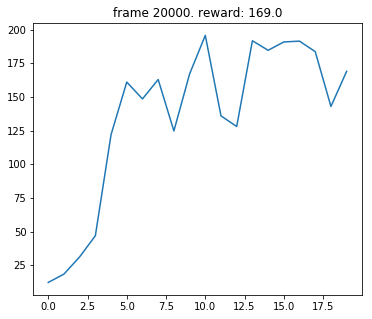

In [331]:
state = envs.reset()

while frame_idx < max_frames:

    log_probs = []
    values    = []
    rewards   = []
    masks     = []
    entropy   = 0

    for _ in range(num_steps):
        # state: [16, 4] (16 multi-agents, 4-d state)
        state = torch.FloatTensor(state).to(device)
        # dist: policy, value: value (not advantage)
        dist, value = model(state)

        action = dist.sample() # on-policy
        next_state, reward, done, _ = envs.step(action.cpu().numpy())

        log_prob = dist.log_prob(action)
        entropy += dist.entropy().mean() # collect entropy https://arxiv.org/pdf/1602.01783.pdf
        
        log_probs.append(log_prob)
        values.append(value)
        rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(device))
        # check done. if done: value = reward
        masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(device))
        
        state = next_state
        frame_idx += 1
        
        if frame_idx % 1000 == 0:
            test_rewards.append(np.mean([test_env() for _ in range(10)]))
            plot(frame_idx, test_rewards)
            
    next_state = torch.FloatTensor(next_state).to(device)
    _, next_value = model(next_state)
    # returns to update
    returns = compute_returns(next_value, rewards, masks)
    
    log_probs = torch.cat(log_probs)
    returns   = torch.cat(returns).detach()
    values    = torch.cat(values)
    
    # adv
    advantage = returns - values
    
    # log(policy) * (R - V)
    actor_loss  = -(log_probs * advantage.detach()).mean() # detach to prevent backpropagation
    # value should be close to return
    critic_loss = advantage.pow(2).mean()

    # total loss
    loss = actor_loss + 0.5 * critic_loss - 0.001 * entropy

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [255]:
dones[19999]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

In [13]:
test_env(False)

NameError: name 'base' is not defined